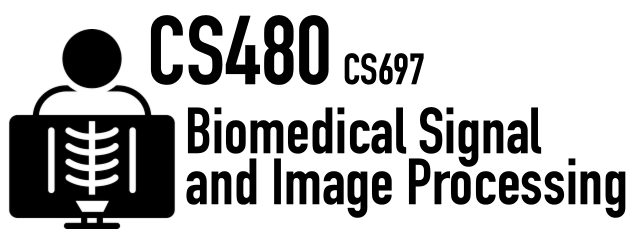


# Assignment 6

**Yiming Shen**

**Apr 26**

In [2]:
# In this assignment, we will train a U-Net classifer to detect mitochondria
# in electron microscopy images!

In [18]:
pip install tensorflow_datasets

     |████████████████████████████████| 3.7 MB 4.3 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 13.4 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 14.7 MB/s eta 0:00:01
     |████████████████████████████████| 198 kB 15.7 MB/s eta 0:00:01
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21494 sha256=6dae3e0cde6be08c39c4dc8c52fbab6f182265d630e8b5979f90d954bb8b9309
  Stored in directory: /Users/ys8230/Library/Caches/pip/wheels/29/93/c6/762e359f8cb6a5b69c72235d798804cae523bbe41c2aa8333d
Successfully built promise
Note: you may need to restart the kernel to use updated packages.


In [3]:
### IMPORTANT ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
#
### IMPORTANT ###

In [4]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
# load the unet tensorflow code
!pip install git+https://github.com/jakeret/unet.git

  Cloning https://github.com/jakeret/unet.git to /private/var/folders/pf/dsx83x096_g0b20b2bw5r1j80000gn/T/pip-req-build-iz73pn34
  Created wheel for unet: filename=unet-0.0.post0.dev81+gf557a51-py2.py3-none-any.whl size=25658 sha256=f5b8586c943444180f03fe7de60569e94ba7fbd684f1f6800eb901965d1d6e4c
  Stored in directory: /private/var/folders/pf/dsx83x096_g0b20b2bw5r1j80000gn/T/pip-ephem-wheel-cache-lzapyhan/wheels/22/00/93/ce57529ed355f160088cbb6ce086e55168770913b40cf624ba
Successfully built unet


In [8]:
# .. and use it!
# Note: There are a ton of U-Net implementations but this one is easier to use!
import unet

**Task 1**: Study the unet circle example and learn about mitochondria! [15 Points]

In [ ]:
# The unet package allows to train a U-Net classifier with little code.
# As discussed in class, the U-Net can be used to label/segment/annotate images.

TODO: Please study the [Circles example](https://github.com/jakeret/unet/blob/master/notebooks/circles.ipynb)

TODO: ... and look [how the (artificial) dataset is generated](https://github.com/jakeret/unet/blob/master/src/unet/datasets/circles.py)

#### 1) Question
TODO: Please describe what the U-Net is trained to do.

TODO: YOUR ANSWER

**U-net was originally invented and used for biomedical image segmentation for the first time. Its architecture can be broadly thought of as an encoder network and then a decoder network. Unlike the final result of a deep network, which is the only important classification, semantic segmentation not only requires pixel-level discrimination, but also requires a mechanism to project the discriminative features learned at different stages of the encoder into the pixel space.**


Reference: [Understanding Semantic Segmentation with UNET](https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47)

#### 2) Question

 TODO: In circles.py, what does the following mean:

     channels = 1
     
     classes = 2

 TODO: YOUR ANSWER
 
**The channels means the depth of the matrices or number of filters involved in the convolutions.**
 
**The classes means the pixel level image classification(background and mitochondria).**

#### 3) Question
 TODO: What are mitochondria and what is their appearance in electron microscopy data?
 Hint: You can validate your answer in Task 4!

 TODO: YOUR ANSWER
 
**Mitochondria are often referred to as the powerhouses of the cell. They help turn the energy we take from food into energy that the cell can use. But, there is more to mitochondria than energy production.**

**Mitochondria are visible with the light microscope but can't be seen in detail. Ribosomes are only visible with the electron microscope.**

**Task 2**: Setup a datagenerator for mitochondria images! [45 Points]

In [ ]:
# TODO: 
# Download https://cs480.org/data/mito.npz to your computer.
# Then, please upload mito.npz using the file panel on the left.

In [ ]:
# The code below is similar to the circles.py file from Task 1.
# We follow Tensorflow conventions to design a tf.data.Dataset for training
# the U-Net.
#
# TODO: Please add four different data augmentation methods in the code block
# below. (image normalization to 0..1, horizontal data flip, vertical data flip,
# rotation by 90 degrees)
#
# Hint: https://github.com/jakeret/unet/blob/master/src/unet/datasets/oxford_iiit_pet.py#L25

In [21]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_datasets.core import DatasetInfo
from typing import Tuple, List

IMAGE_SIZE = (256, 256)
channels = 1
classes = 2

def load_data(count:int, splits:Tuple[float]=(0.7, 0.2, 0.1), **kwargs) -> List[tf.data.Dataset]:
    return [tf.data.Dataset.from_tensor_slices(_build_samples(int(split * count), **kwargs))
            for split in splits]


def _build_samples(sample_count:int, **kwargs) -> Tuple[np.array, np.array]:

    # here we load the mitochondria data
    loaded = np.load('mito.npz')
    loadedimages = loaded['arr_0'][0].copy()
    loadedmasks = loaded['arr_0'][1].copy()

    # now let's go to numpyland
    images = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
    labels = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 2))
    for i in range(sample_count):
        image, mask = loadedimages[i], loadedmasks[i]

        image = image.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1)).astype(np.float)
        mask = mask.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1))

        #
        # TODO: Normalize the image to 0..1
        #
        image = tf.cast(image,tf.float32)/255.0
        mask -= 1# TODO: YOUR CODE
         

        #
        # TODO: Use Tensorflow to flip the image horizontally
        #
        if tf.random.uniform(()) > 0.5:
            #
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask) # TODO: YOUR CODE
            

        #
        # TODO: Use Tensorflow to flip the image vertically
        #
        if tf.random.uniform(()) > 0.5:
            #
            image = tf.image.flip_up_down(image)
            mask = tf.image.flip_up_down(mask)# TODO: YOUR CODE
            #

        #
        # TODO: Use Tensorflow to rotate the image 90 degrees
        #
        if tf.random.uniform(()) > 0.5:
            #
            image = tf.image.rot90(image)
            mask = tf.image.rot90(mask)# TODO: YOUR CODE
            #


        # augmentation done, let's store the image
        images[i] = image

        # here we split the mask to background and foreground
        fg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        fg[mask == 255] = 1
        bg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        bg[mask == 0] = 1
        
        labels[i, :, :, 0] = bg[:,:,0]
        labels[i, :, :, 1] = fg[:,:,0]

    return images, labels

**Task 3**: Let's train the U-Net! [25 Points]

In [22]:
#
# We can now create our training, validation, and testing data by calling
# our methods from Task 2.
#
train, val, test = load_data( 660, splits=(0.7, 0.2, 0.1) )

In [23]:
train

<TensorSliceDataset shapes: ((256, 256, 1), (256, 256, 2)), types: (tf.float64, tf.float64)>

In [24]:
val

<TensorSliceDataset shapes: ((256, 256, 1), (256, 256, 2)), types: (tf.float64, tf.float64)>

In [ ]:
# 1) Question
# TODO: We have in total 660 images + 660 masks. Based on the code above,
# how many images are used for training alone?
#
# TODO: YOUR ANSWER

In [25]:
#
# Let's setup the U-Net!
#
LEARNING_RATE = 1e-3

unet_model = unet.build_model(channels=channels,
                              num_classes=classes,
                              layer_depth=5,
                              filters_root=64,
                              padding="same")

unet.finalize_model(unet_model, learning_rate=LEARNING_RATE)

In [26]:
#
# And, let's setup the trainer...
#
trainer = unet.Trainer(checkpoint_callback=False,
                       learning_rate_scheduler=unet.SchedulerType.WARMUP_LINEAR_DECAY,
                       warmup_proportion=0.1,
                       learning_rate=LEARNING_RATE)

In [27]:
#
# ...and train the U-Net for 50 epochs with a batch_size of 10!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use training and validation data.
# Hint 2: This will take roughly 30 minutes!
#
trainer.fit(unet_model, train, val, epochs = 50, batch_size = 10
            #
            # TODO: YOUR CODE
            #
            #
            )

Epoch 1/50
47/47 [==============================] - 914s 19s/step - loss: 0.5559 - categorical_crossentropy: 0.5559 - categorical_accuracy: 0.5218 - mean_iou: 0.2666 - dice_coefficient: 0.5372 - auc: 0.6527 - val_loss: 0.3464 - val_categorical_crossentropy: 0.3464 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.3325 - val_dice_coefficient: 0.6720 - val_auc: 0.9928
Epoch 2/50
47/47 [==============================] - 871s 18s/step - loss: 0.1052 - categorical_crossentropy: 0.1052 - categorical_accuracy: 0.9209 - mean_iou: 0.4175 - dice_coefficient: 0.8608 - auc: 0.9684 - val_loss: 0.3968 - val_categorical_crossentropy: 0.3968 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.3160 - val_dice_coefficient: 0.6370 - val_auc: 0.9941
Epoch 3/50
47/47 [==============================] - 879s 19s/step - loss: 0.0980 - categorical_crossentropy: 0.0980 - categorical_accuracy: 0.9210 - mean_iou: 0.4212 - dice_coefficient: 0.8660 - auc: 0.9758 - val_loss: 0.2126 - val_categorical_crossentropy

 It takes too long time, more than 10 hours..

**Task 4**: Let's predict mitochondria in the testing data! [15 Points]

In [ ]:
# 
# After training, let's try the U-Net on our testing data.
#
# The code below displays the first 10 input images, the original masks by experts, 
# and the predicted masks from the U-Net.

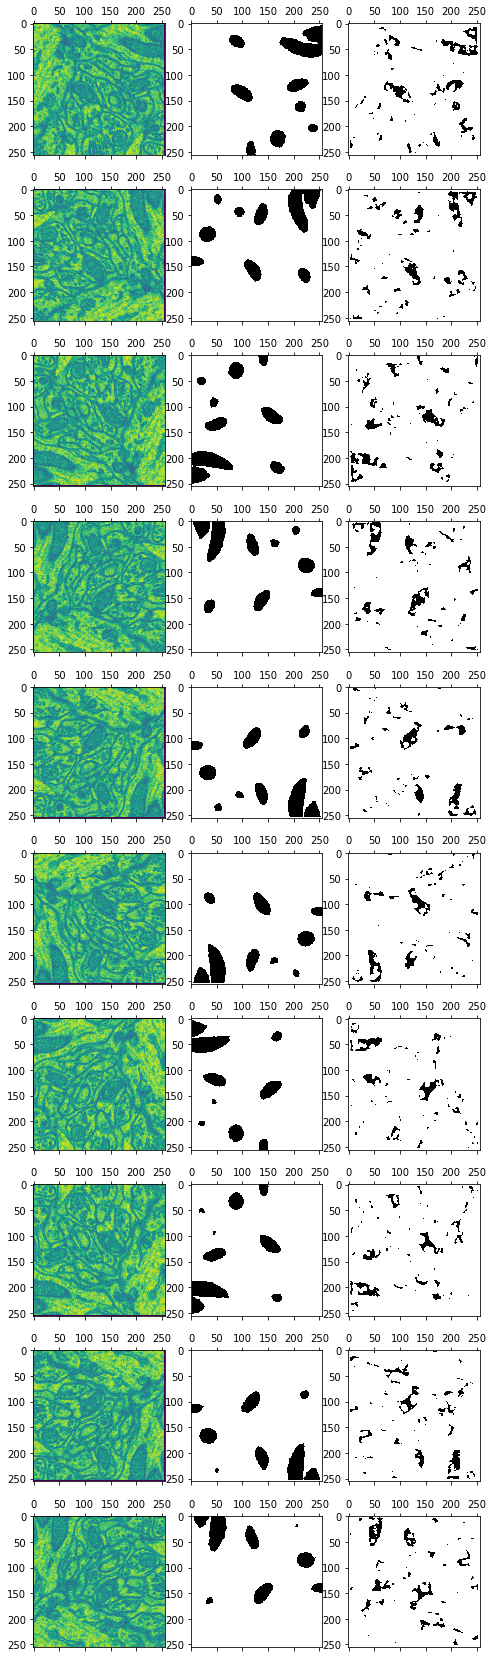

In [28]:
rows = 10
fig, axs = plt.subplots(rows, 3, figsize=(8, 30))
for ax, (image, label) in zip(axs, test.take(rows).batch(1)):
  
  prediction = unet_model.predict(image)
  ax[0].matshow(image[0, :, :, 0])
  ax[1].matshow(label[0, :, :, 1], cmap="gray")
  ax[2].matshow(prediction[0].argmax(axis=-1), cmap="gray")

#### 1) Question
 TODO: Why do we use the prediction[0].argmax(axis=-1) command
 to display the prediction?
 
 TODO: YOUR ANSWER
 
 
**The prediction is a 3D array and the prediction[0] is the image dataset which is 256*256*2.**

**The argmax is used to find the largest predicted class**

#### 2) Question
 TODO: Is the quality of the segmentation good and how could we improve it?
 
 Hint: Think along the lines of some traditional image processing rather than increasing the training data size.

 TODO: YOUR ANSWER
 
 
**I think the quality of the segmentation is acceptable. Besides, the most efficiency way is feeding more noisy dataset to the model then identify the right segmentation criteria.**

**Bonus**: Compare against the state-of-the-art literature! [33 Points]

In [ ]:
#
# The following paper also uses a 2D U-Net to detect mitochondria:
# 
# https://danielhaehn.com/papers/?casser2020fast
#

In [ ]:
# 1) Question
#
# TODO: How many learnable parameters does your trained unet_model have?
# Hint: You can use TF's Model Summary function to answer this.
#

In [ ]:
# TODO: YOUR CODE

In [29]:
prediction[0].shape

(256, 256, 2)

In [30]:
prediction[0].argmax(axis=-1)

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [31]:
unet_model.summary()

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_block (ConvBlock)          (None, None, None, 6 37568       inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 6 0           conv_block[0][0]                 
__________________________________________________________________________________________________
conv_block_1 (ConvBlock)        (None, None, None, 1 221440      max_pooling2d[0][0]              
_______________________________________________________________________________________________

In [ ]:
# 2) Question
#
# TODO: How many parameters do Casser et al. use?
#

 TODO: YOUR ANSWER
 
**Casser et al. used 1,178,480 for encoder and 780,053 parameters for decoder.**

In [ ]:
# 3) Question
#
# TODO: How did Casser et al. reduce the parameters?
#

**We can try to reduce the number of convolutional filters throughout the network, then using more specific trained functions to replace the transpose convolutions.**

In [ ]:
# 4) Question
#
# TODO: Why did Casser et al. reduce the parameters?
#

**By using this way, we can get higher accuracy and faster processing speed in the automated image segmentation.**

In [ ]:
#
# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#